# Project 90 dataset

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

import pystan as ps
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import arviz as az
sns.set()

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData
from crawford_algorithm import simulating_rds_crawford, Crawford

In [3]:
rds_b = pickle.load(open('../models/prevalence_estimation/pickles/RDS_B_estimator.pkl', 'rb')) 
rds_model = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))

In [4]:
data_project90 = pd.read_csv('../data/Princeton_project_90/nodes.tsv', sep='\t')
edges_project90 = pd.read_csv('../data/Princeton_project_90/edges.tsv', sep='\t')

In [5]:
graph = nx.Graph()
for i, edge in edges_project90.iterrows():
    graph.add_node(edge['node1'], data=data_project90[data_project90.id == edge['node1']])
    graph.add_node(edge['node2'], data=data_project90[data_project90.id == edge['node2']])
    graph.add_edge(edge['node1'], edge['node2'])
components = list(nx.connected_components(graph))
G = graph.subgraph(components[0])

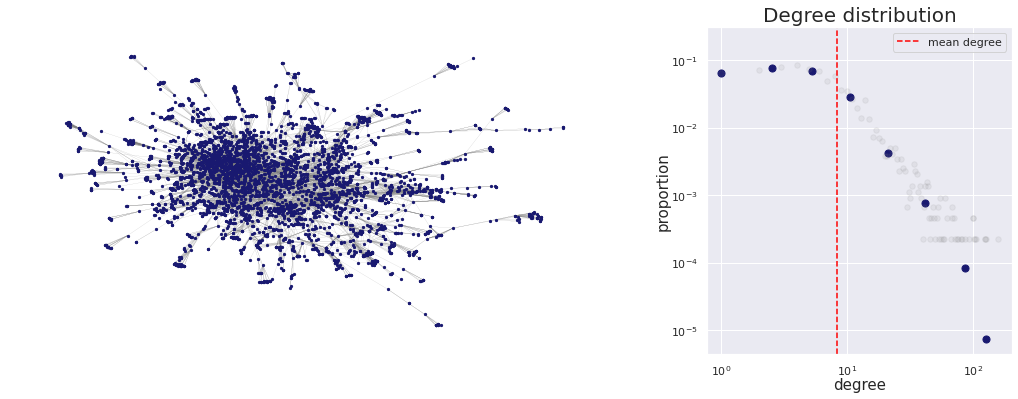

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios':(2,1)})

nx.draw(G, node_size=5, node_color='midnightblue', edge_color='grey', ax=ax[0], width=0.1)

degree_histogram = np.array(nx.degree_histogram(G))[1:]
degree_histogram = degree_histogram/degree_histogram.sum()

d_max = len(degree_histogram) - 1
n_max = int(np.log2(len(degree_histogram)))

# Log-binning
log_binning = np.zeros(n_max+1)
degree_histogram_log_binning = np.zeros(n_max+1)
for n in range(n_max+1): 
    bins = np.array([2**n + i for i in range(min(2**n, d_max - 2**n))])
    N_n = degree_histogram[bins].sum()
    degree_histogram_log_binning[n] = N_n/len(bins)
    log_binning[n] = (bins*degree_histogram[bins]).sum()/N_n
    
degrees = np.where(degree_histogram != 0)
        
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].axvline(np.array(G.degree)[:,1].mean(), linestyle='--', color='red', label='mean degree')

ax[1].scatter(log_binning, degree_histogram_log_binning, color = 'midnightblue', s = 50)
ax[1].scatter(degrees, degree_histogram[degrees], color = 'grey', alpha = 0.1, s = 30)
ax[1].set_title('Degree distribution', fontsize=20)
ax[1].set_xlabel('degree', labelpad = 0, fontsize=15)
ax[1].set_ylabel('proportion', labelpad = 0, fontsize=15)

ax[1].legend()

#plt.savefig('../images/graph_projet90_degree_distribution.pdf', bbox_inches='tight')
plt.show()

Deliting incomplete data and getting the larger component.

In [7]:
# removing 
df_project90 = data_project90.dropna()
graph        = graph.subgraph(df_project90.id)

# Getting the larger subgraph
components = list(nx.connected_components(graph))
subgraph   = graph.subgraph(components[0])
 
# Subgraph 
nodes = list(subgraph.nodes)
df    = df_project90[df_project90.id.isin(nodes)]

In [8]:
df.disabled.value_counts(dropna=False, normalize=True)

0.0    0.953053
1.0    0.046947
Name: disabled, dtype: float64

In [9]:
for i in range(1, 5):
    df.loc[:, 'race_{}'.format(i)] = 1 * (df['race'] == i)
    
spec    = 0.85
sens    = 0.9
p       = sens * df.disabled + (1 - df.disabled) * (1 - spec)
ro = np.random.RandomState(seed=738129)
df.loc[: ,'test'] = ro.binomial(n=1, p=p)
    
df = df.set_index('id').drop(columns=['race', 'disabled'])

/home/lucasmoschen/anaconda3/envs/tcc-emap/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [38]:
n_samples = 500
gen_graph = GenerateData()
rds_sample = gen_graph.RDS_generator(graph = subgraph, seed=2515, 
                                     n_seeds=10, sample_size = n_samples, 
                                     probs = [1/3,1/6,1/6,1/3], R=0)
rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
rds_data = df.loc[list(rds_sample.nodes)]

In [39]:
A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

In [40]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 0, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [41]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 479 ms, sys: 56.2 ms, total: 535 ms
Wall time: 1min 1s


In [42]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.068,0.069,0.000,0.191,0.001,0.001,1774.0,3340.0,1.00
sens,0.884,0.076,0.749,0.998,0.001,0.001,8034.0,4485.0,1.00
spec,0.863,0.049,0.781,0.955,0.002,0.001,791.0,1496.0,1.01
effects[0],-0.004,0.683,-1.369,1.244,0.010,0.008,5364.0,4590.0,1.00
effects[1],-0.084,0.745,-1.454,1.387,0.008,0.010,7865.0,5133.0,1.00
effects[2],-0.187,0.883,-1.950,1.422,0.010,0.010,8292.0,5986.0,1.00
effects[3],-0.822,0.856,-2.420,0.787,0.013,0.009,4604.0,4597.0,1.00
effects[4],0.076,0.721,-1.337,1.404,0.009,0.008,7027.0,4481.0,1.00
effects[5],0.152,0.987,-1.676,2.065,0.010,0.011,9173.0,5636.0,1.00
effects[6],0.032,0.819,-1.618,1.505,0.008,0.010,9778.0,5950.0,1.00


In [43]:
rds_crawford = simulating_rds_crawford(subgraph, n_samples=500, n_seeds=10, rate=1/5, probs=[1/3, 1/6, 1/6, 1/3], seed=777)#421412)
rds_crawford['rds'].remove_nodes_from(list(nx.isolates(rds_crawford['rds'])))
rds_data = df.loc[list(rds_crawford['rds'].nodes)]

100%|██████████| 494/494 [00:00<00:00, 3825.33it/s]


In [44]:
A = nx.adjacency_matrix(rds_crawford['rds'].to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [45]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 554 ms, sys: 48.1 ms, total: 602 ms
Wall time: 59 s


In [46]:
az.summary(fit_imperfect_rds, hdi_prob=.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.101,0.075,0.007,0.154,0.001,0.001,3890.0,4679.0,1.00
sens,0.891,0.072,0.833,0.990,0.001,0.000,11408.0,4836.0,1.00
spec,0.907,0.035,0.862,0.955,0.001,0.000,3112.0,3397.0,1.00
effects[0],0.087,0.518,-0.492,0.778,0.006,0.006,7119.0,5197.0,1.00
effects[1],0.487,0.549,-0.227,1.121,0.007,0.006,6687.0,5359.0,1.00
effects[2],-0.879,0.772,-1.842,0.088,0.007,0.007,12678.0,6036.0,1.00
effects[3],-0.939,0.744,-1.842,0.037,0.007,0.006,12138.0,5593.0,1.00
effects[4],0.775,0.483,0.168,1.354,0.005,0.004,9382.0,5709.0,1.00
effects[5],0.667,0.879,-0.406,1.807,0.008,0.008,13267.0,5676.0,1.00
effects[6],0.512,0.619,-0.220,1.317,0.006,0.006,12357.0,5645.0,1.00


In [47]:
n_samples = 500
gen_graph = GenerateData()

seeds = []
while len(seeds) < 10:
    i = np.random.choice(subgraph.nodes)
    if (subgraph.nodes[i]['data'])['disabled'].iloc[0] == 1:
        seeds.append(i)
seeds = np.array(seeds)

rds_sample = gen_graph.RDS_generator(graph = subgraph, seed=555,#2000, 
                                     n_seeds=10, sample_size = n_samples, 
                                     probs = [1/3,1/6,1/6,1/3], R=0, seeds=seeds)
rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
rds_data = df.loc[list(rds_sample.nodes)]

In [48]:
A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [49]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho', 'omega'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 8.6 s, sys: 176 ms, total: 8.78 s
Wall time: 2min 15s


In [50]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.095,0.080,0.000,0.241,0.002,0.001,2269.0,3067.0,1.00
sens,0.890,0.070,0.761,0.993,0.001,0.001,7283.0,5005.0,1.00
spec,0.865,0.036,0.799,0.937,0.001,0.001,1978.0,1979.0,1.00
effects[0],-0.473,0.640,-1.716,0.704,0.009,0.007,5467.0,5121.0,1.00
effects[1],-0.028,0.694,-1.404,1.229,0.010,0.008,5277.0,4961.0,1.00
...,...,...,...,...,...,...,...,...,...
omega[493],-0.114,1.245,-2.314,2.102,0.032,0.033,2659.0,735.0,1.00
omega[494],-0.175,1.238,-2.525,2.015,0.022,0.035,6156.0,1008.0,1.01
omega[495],-0.008,0.736,-1.167,1.342,0.014,0.021,5498.0,704.0,1.01
omega[496],0.065,1.238,-2.027,2.508,0.019,0.033,5360.0,1685.0,1.00


<AxesSubplot:title={'center':'prev'}>

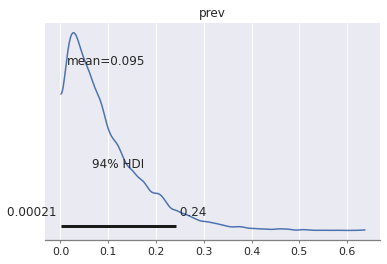

In [52]:
az.plot_posterior(fit_imperfect_rds, var_names=['prev'])

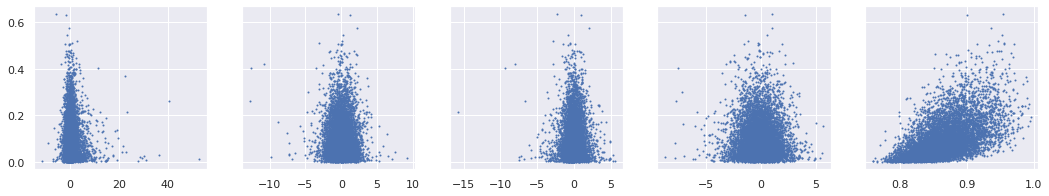

In [53]:
fig, ax = plt.subplots(1,5, figsize=(18,3), sharey=True)

prev_posterior = fit_imperfect_rds.extract()['prev']
omega_posterior = fit_imperfect_rds.extract()['omega']

s=1
ax[0].scatter(omega_posterior[:, 447], prev_posterior, s=s)
ax[1].scatter(omega_posterior[:, 41], prev_posterior, s=s)
ax[2].scatter(omega_posterior[:, 222], prev_posterior, s=s)
ax[3].scatter(omega_posterior[:, 282], prev_posterior, s=s)
#ax[4].scatter(omega_posterior[:, 478], prev_posterior, s=s)
ax[4].scatter(fit_imperfect_rds.extract()['spec'], prev_posterior, s=s)


## Another variable

In [65]:
df    = df_project90[df_project90.id.isin(nodes)]

for i in range(1, 5):
    df.loc[:, 'race_{}'.format(i)] = 1 * (df['race'] == i)
    
spec    = 0.85
sens    = 0.9
p       = sens * df.homeless + (1 - df.homeless) * (1 - spec)
ro = np.random.RandomState(seed=738129)
df.loc[: ,'test'] = ro.binomial(n=1, p=p)

print(df.homeless.value_counts(dropna=False, normalize=True))
    
df = df.set_index('id').drop(columns=['race', 'homeless'])

0.0    0.984919
1.0    0.015081
Name: homeless, dtype: float64


/home/lucasmoschen/anaconda3/envs/tcc-emap/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [62]:
n_samples = 500
gen_graph = GenerateData()
rds_sample = gen_graph.RDS_generator(graph = subgraph, seed=2515, 
                                     n_seeds=10, sample_size = n_samples, 
                                     probs = [1/3,1/6,1/6,1/3], R=0)
rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
rds_data = df.loc[list(rds_sample.nodes)]

In [64]:
df

,gender,sex.worker,pimp,sex.work.client,drug.dealer,drug.cook,thief,retired,housewife,disabled,unemployed,race_1,race_2,race_3,race_4,test
id,,,,,,,,,,,,,,,,
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1,1
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0,1,0
3,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
5,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
5486,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
5487,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1,1


In [58]:
A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [59]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho',), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 474 ms, sys: 60.1 ms, total: 534 ms
Wall time: 1min 6s


In [60]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.058,0.064,0.000,0.179,0.001,0.001,3419.0,4714.0,1.00
sens,0.891,0.072,0.759,0.996,0.001,0.000,9361.0,5085.0,1.00
spec,0.849,0.032,0.795,0.915,0.001,0.000,2741.0,2882.0,1.00
effects[0],-0.262,0.763,-1.733,1.165,0.008,0.008,9201.0,5967.0,1.00
effects[1],0.269,0.871,-1.409,1.900,0.010,0.010,8015.0,5819.0,1.00
effects[2],-0.466,0.923,-2.195,1.300,0.010,0.009,8279.0,5990.0,1.00
effects[3],-0.492,0.882,-2.173,1.143,0.010,0.009,8141.0,5781.0,1.00
effects[4],0.438,0.865,-1.269,2.030,0.010,0.008,7640.0,5573.0,1.00
effects[5],0.096,0.993,-1.763,1.931,0.009,0.012,11010.0,6200.0,1.00
effects[6],0.052,0.888,-1.627,1.716,0.009,0.010,10425.0,6077.0,1.00
